In [1]:
import collections
import itertools
import json
import datetime
import time

import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

# Data Imports

In [10]:
language = "javascript"
path_to_lib = f"data/results/{language}"

In [11]:
with open(f"{path_to_lib}/{language}_{language}_daily_post_stats.json") as handle:
    daily_post_count = json.load(handle)

with open(f"{path_to_lib}/{language}_post_to_libs.json") as handle:
    post_to_libs = json.load(handle)

with open(f"{path_to_lib}/{language}_libs_count.json") as handle:
    libs_count = json.load(handle)
    
with open(f"{path_to_lib}/{language}_pairs_count.json") as handle:
    pairs_count = json.load(handle)
    
with open(f"{path_to_lib}/{language}_all_libs_dates.json") as handle:
    all_libs_dates = json.load(handle)
    
with open(f"{path_to_lib}/{language}_all_pairs_dates.json") as handle:
    all_pairs_dates = json.load(handle)
    
with open(f"{path_to_lib}/{language}_libs_first_dates.json") as handle:
    libs_first_dates = json.load(handle)
    
with open(f"{path_to_lib}/{language}_pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

# New libs and pairs (y axis) against post count (x axis)

Segments formed (took 0.13 seconds).
Fits performed (took 0.06 seconds).


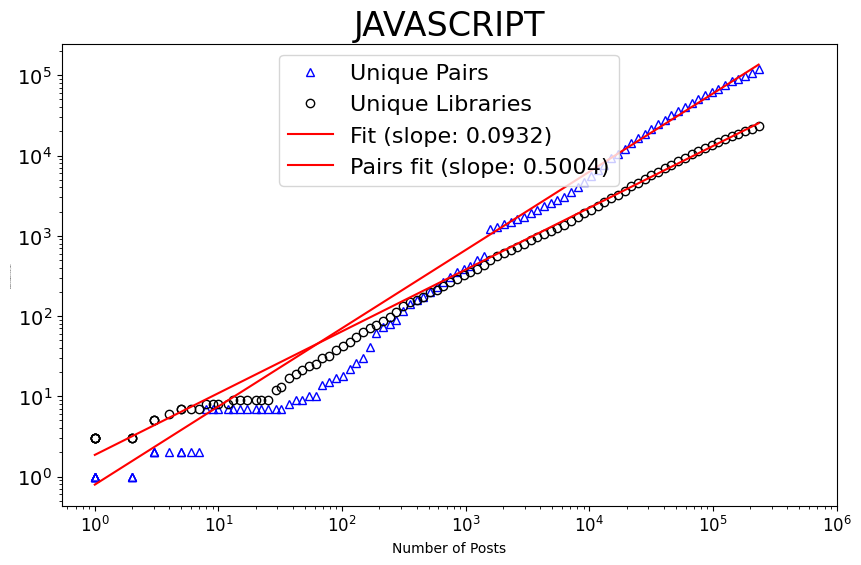

In [12]:
t0 = time.time()
xs_libs = np.array([d[0] for d in post_to_libs['distinct_libs_plot']])
ys_libs = np.array([d[1] for d in post_to_libs['distinct_libs_plot']])
xs_pairs = [d[0] for d in post_to_libs['distinct_pairs_plot']]
ys_pairs = [d[1] for d in post_to_libs['distinct_pairs_plot']]
t1 = time.time()
print(f"Segments formed (took {round(t1 - t0, 2)} seconds).")

# Unique libs line fit
libs_a, libs_b  = np.polyfit(range(len(xs_libs)), ys_libs, 1)
pairs_a, pairs_b = np.polyfit(range(len(xs_pairs)), ys_pairs, 1)
t2 = time.time()
print(f"Fits performed (took {round(t2 - t1, 2)} seconds).")


step_size = 100 #len(xs_libs) // 1000
plt.figure(figsize=(10,6))
#xs = np.array(range(0, len(xs_libs), step_size))

xs = [int(x) for x in np.geomspace(1, len(xs_libs)-1, 100)]
plt.plot(xs, [ys_pairs[i] for i in xs], "^", color="blue", markerfacecolor='none',  label="Unique Pairs")
plt.plot(xs, [ys_libs[i] for i in xs],"o", color="black", markerfacecolor='none', label="Unique Libraries")

plt.xticks(fontsize=12)
plt.title(f"{language.upper()}", fontsize=24)
plt.xlabel("Number of Posts", fontsize=10)
plt.ylabel("Number of Unique Libraries / Pairs", fontsize=1)

plt.yticks(fontsize=14)


full_xs = np.array(range(0, len(xs_libs)))
libs_log_xs = np.log10(full_xs[1:])
libs_log_ys= np.log10(ys_libs[1:])
libs_m, libs_b  = np.polyfit(libs_log_xs, libs_log_ys, 1)


pairs_log_xs = np.log10(full_xs[1:])
pairs_log_ys= np.log10(ys_pairs[1:])
pairs_m, pairs_b  = np.polyfit(pairs_log_xs, pairs_log_ys, 1)

plt.plot(
    full_xs[1:],
    10**libs_b * full_xs[1:]**libs_m,
    "r-",
    label=f"Fit (slope: {round(libs_a, 4)})")
plt.plot(
    full_xs[1:],
    10**pairs_b * full_xs[1:]**pairs_m,
    "r",
    label=f"Pairs fit (slope: {round(pairs_a, 4)})")
plt.loglog()

plt.xticks(ticks=[10**i for i in range(0, 7)], fontsize=12)
plt.legend(loc="upper center", fontsize=16)


# Examine Valuable Novelties

In [40]:
WINDOW_DAYS = 365
VALUE_THRESHOLD_IN_WINDOW = 12

def get_dates_count_in_window(start_date_str: str, dates: list):
    start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
    cnt = 0
    index = 0
    while (
        index < len(dates) and 
        datetime.datetime.strptime(dates[index], "%Y-%m-%d") < start_date + datetime.timedelta(days=WINDOW_DAYS)
    ):
        cnt += 1
        index += 1
    return cnt
    
valuable_libs = set([
    k for k, v in libs_first_dates.items() if
    get_dates_count_in_window(v['date'], all_libs_dates[k]) >= VALUE_THRESHOLD_IN_WINDOW
])
valuable_pairs = set([
    k for k, v in pairs_first_dates.items() if
    get_dates_count_in_window(v['date'], all_pairs_dates[k]) >= VALUE_THRESHOLD_IN_WINDOW
])

In [41]:
def iter_items(parser):
    for prefix, event, value in parser:
        if event == 'string':
            yield prefix, value

loot = {}
date, imports = None, []
with open(f"data/results/{language}/{language}_{language}_post_stats.json") as infile:
    for prefix, event, value in tqdm.tqdm(ijson.parse(infile)):
        if prefix == "item.date":
            date = value
        elif prefix == "item.imports.item":
            imports.append(value)
        elif event == "end_map":
            loot[date] = imports
            date, imports = None, []
        #print(f"prefix: {prefix}, event: {event}, value: {value}")


56008255it [00:38, 1438309.16it/s]


In [42]:
val_xs, val_libs_ys, val_pairs_ys = [], [], []
value_libs_count = 0
value_pairs_count = 0
libs_have_seen = set()
pairs_have_seen = set()
for date, libs in tqdm.tqdm(list(loot.items())):
    # Search for new individual libraries
    value_lib_found = False
    for lib in libs:
        if lib in libs_have_seen:
            continue
        libs_have_seen.add(lib)
        if lib in valuable_libs:
            value_lib_found = True
    if value_lib_found:
        value_libs_count += 1
    
    #Search for new combinations
    value_pair_found = False
    for lib_a, lib_b in itertools.combinations(libs, 2):
        canonical_pair_name = "|".join(sorted([lib_a, lib_b]))
        if canonical_pair_name in pairs_have_seen:
            continue
        pairs_have_seen.add(canonical_pair_name)
        if canonical_pair_name in valuable_pairs:
            value_pair_found = True
    if value_pair_found:
        value_pairs_count += 1

    val_xs.append(date)
    val_libs_ys.append(value_libs_count)
    val_pairs_ys.append(value_pairs_count)


100%|████████████████████████████| 3114958/3114958 [00:02<00:00, 1420411.29it/s]


Segments formed (took 1.2 seconds).


([<matplotlib.axis.XTick at 0x797d60e610f0>,
 [Text(1, 0, '$\\mathdefault{10^{0}}$'),
  Text(10, 0, '$\\mathdefault{10^{1}}$'),
  Text(100, 0, '$\\mathdefault{10^{2}}$'),
  Text(1000, 0, '$\\mathdefault{10^{3}}$'),
  Text(10000, 0, '$\\mathdefault{10^{4}}$'),
  Text(100000, 0, '$\\mathdefault{10^{5}}$'),
  Text(1000000, 0, '$\\mathdefault{10^{6}}$')])

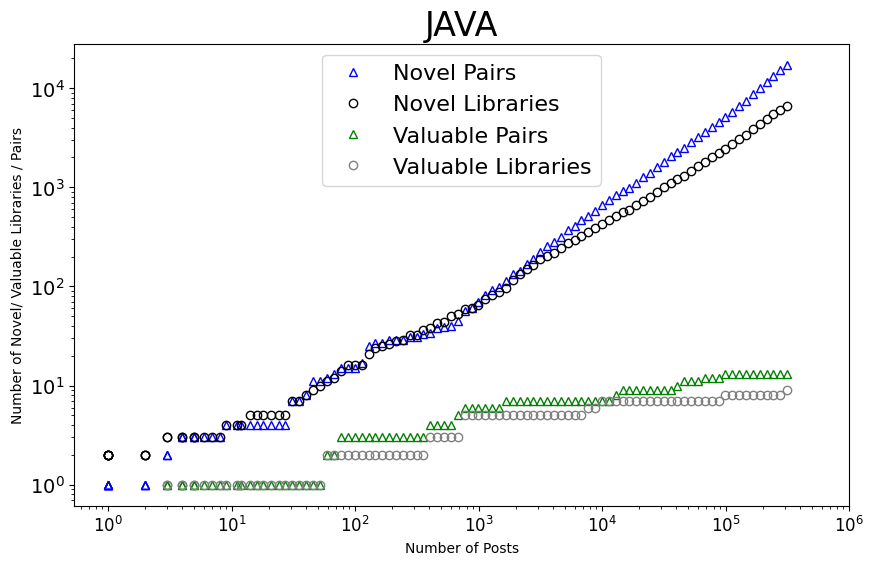

In [43]:
t0 = time.time()
xs_libs_val = np.array(val_xs)
ys_libs_val = np.array(val_libs_ys)
xs_pairs_val = np.array(val_xs)
ys_pairs_val = np.array(val_pairs_ys)
t1 = time.time()
print(f"Segments formed (took {round(t1 - t0, 2)} seconds).")


step_size = 100 #len(xs_libs) // 1000
plt.figure(figsize=(10,6))
xs = np.array(range(0, len(xs_libs), step_size))

xs = [int(x) for x in np.geomspace(1, len(xs_libs)-1, 100)]
plt.plot(xs, [ys_pairs[i] for i in xs], "^", color="blue", markerfacecolor='none',  label="Novel Pairs")
plt.plot(xs, [ys_libs[i] for i in xs],"o", color="black", markerfacecolor='none', label="Novel Libraries")

plt.plot(xs, [ys_pairs_val[i] for i in xs], "^", color="green", markerfacecolor='none',  label="Valuable Pairs")
plt.plot(xs, [ys_libs_val[i] for i in xs],"o", color="grey", markerfacecolor='none', label="Valuable Libraries")





plt.xticks(fontsize=12)
plt.title(f"{language.upper()}", fontsize=24)
plt.xlabel("Number of Posts", fontsize=10)
plt.ylabel("Number of Novel/ Valuable Libraries / Pairs", fontsize=10)

plt.yticks(fontsize=14)
plt.legend(loc="upper center", fontsize=16)


plt.loglog()

plt.xticks(ticks=[10**i for i in range(0, 7)], fontsize=12)

# Post count, lib count, pair count (y axis) against time (x axis)

In [25]:
print(len(libs_first_dates.keys()), len(all_libs_dates.keys()))
print(libs_first_dates.keys() == all_libs_dates.keys())
for k in list(libs_first_dates.keys())[:10]:
    print(f"{libs_first_dates[k]} <-> {all_libs_dates[k][0]}")

66498 66498
True
{'id': '802', 'poster_id': '1384652', 'date': '2008-08-03'} <-> 2008-08-03
{'id': '802', 'poster_id': '1384652', 'date': '2008-08-03'} <-> 2008-08-03
{'id': '802', 'poster_id': '1384652', 'date': '2008-08-03'} <-> 2008-08-03
{'id': '982', 'poster_id': '200', 'date': '2008-08-04'} <-> 2008-08-04
{'id': '1829', 'poster_id': '30', 'date': '2008-08-05'} <-> 2008-08-05
{'id': '1840', 'poster_id': '116', 'date': '2008-08-05'} <-> 2008-08-05
{'id': '1840', 'poster_id': '116', 'date': '2008-08-05'} <-> 2008-08-05
{'id': '1840', 'poster_id': '116', 'date': '2008-08-05'} <-> 2008-08-05
{'id': '1852', 'poster_id': '116', 'date': '2008-08-05'} <-> 2008-08-05
{'id': '2311', 'poster_id': '394', 'date': '2008-08-05'} <-> 2008-08-05


In [6]:
def get_time_buckets(start, end, default_value=0):
    time_buckets = {}
    runner = datetime.datetime(*[int(item) for item in start.split("-")])
    delta = datetime.timedelta(days=1)
    while runner < datetime.datetime(*[int(item) for item in end.split("-")]):
        time_buckets[runner.strftime("%Y-%m-%d")] = default_value
        runner += delta
    return time_buckets

In [7]:
start = "2008-1-1"
end =  "2024-1-1"


xs = list(get_time_buckets(start, end).keys())

libs_buckets = get_time_buckets(start, end)
for v in libs_first_dates.values():
    libs_buckets[v["date"]] += 1
libs_ys = list(pd.Series(libs_buckets).cumsum())

pairs_buckets = get_time_buckets(start, end)
for v in pairs_first_dates.values():
    pairs_buckets[v["date"]] += 1
pairs_ys = list(pd.Series(pairs_buckets).cumsum())

post_counts_buckets =  get_time_buckets(start, end)
post_counts_buckets.update({
    k: v for k, v in daily_post_count.items() if
    datetime.datetime.strptime(start, "%Y-%m-%d") <= datetime.datetime.strptime(k, "%Y-%m-%d") < datetime.datetime.strptime(end, "%Y-%m-%d")
})
post_counts_ys = list(pd.Series(post_counts_buckets).cumsum())

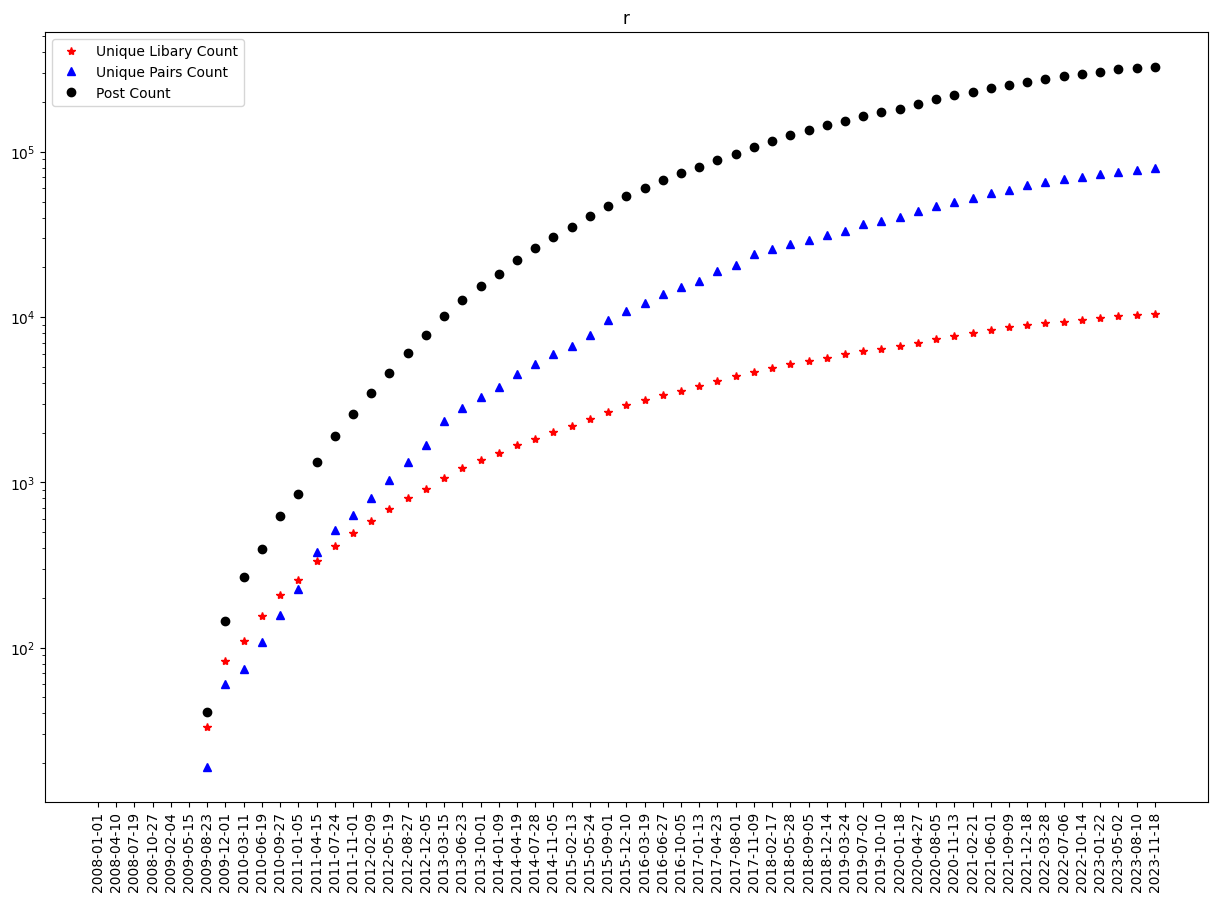

In [8]:
step_size = 100

plt.figure(figsize=(15,10))

plt.plot(xs[::step_size], libs_ys[::step_size], "r*", label="Unique Libary Count")
plt.plot(xs[::step_size], pairs_ys[::step_size], "b^", label="Unique Pairs Count")
plt.plot(xs[::step_size], post_counts_ys[::step_size], "ko", label="Post Count")
plt.title(language)
plt.xticks(rotation=90)
plt.semilogy()
plt.legend(loc="upper left")

# Frequency of libs spread across the years (x axis)

In [9]:
start = "2008-1-1"
end =  "2024-1-1"
delta = datetime.timedelta(days=365)
rolling_window = 30

xs = list(get_time_buckets(start, end))

scatters_x, scatters_y = [],  []
avg = collections.defaultdict(list)
# only checking number of uses in the year following the first appearance
for lib_name, first_appeared in tqdm.tqdm(libs_first_dates.items()):
    first_appeared_dt = datetime.datetime.strptime(first_appeared["date"], "%Y-%m-%d")
    usage_cnt = len(
        [dt for dt in all_libs_dates[lib_name]
         if first_appeared_dt <= datetime.datetime.strptime(dt, "%Y-%m-%d")  < first_appeared_dt + delta]
    )
    scatters_x.append(first_appeared_dt)
    scatters_y.append(usage_cnt)
    avg[first_appeared_dt.strftime("%Y-%m-%d")].append(usage_cnt)

df = pd.DataFrame(avg.items(), columns=['dates', 'counts'])
df['dates_dt'] = df.dates.apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d"))
df['averages'] = df.counts.apply(lambda row: sum(row) / len(row))
df['roller'] = df.averages.rolling(rolling_window).mean()


100%|█| 10478/10478 [00:02<00:00, 3


[]

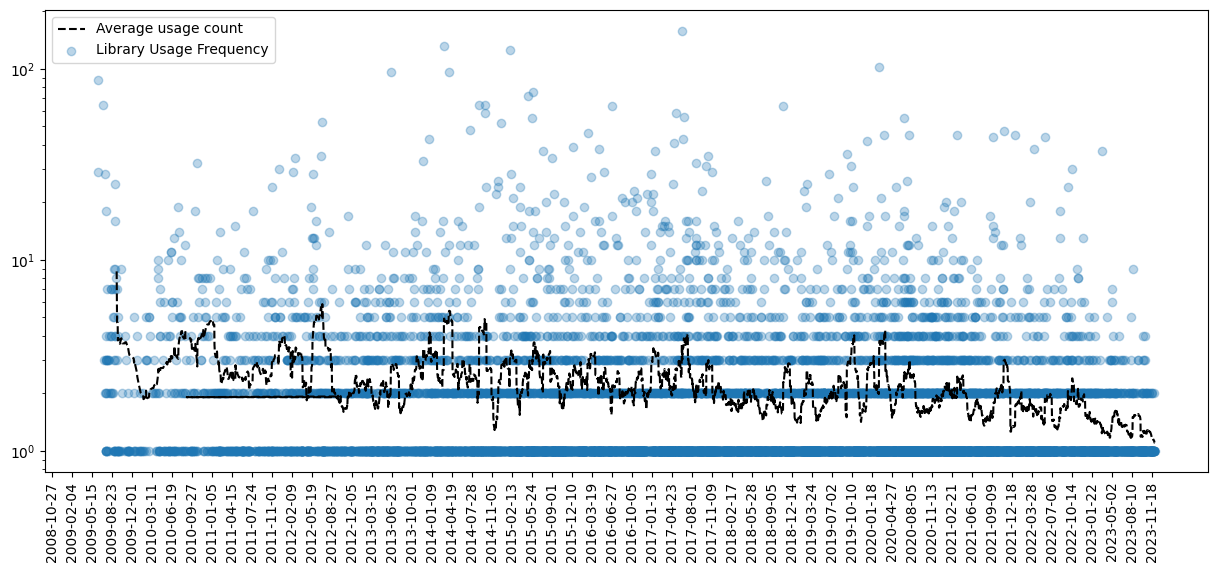

In [10]:
plt.figure(figsize=(15,6))
plt.plot(list(df.dates_dt),list(df.roller), "k--", label="Average usage count")
plt.scatter(scatters_x, scatters_y, alpha=0.3, label="Library Usage Frequency")
plt.xticks(xs[::100], rotation=90)
plt.legend(loc="upper left")
plt.semilogy()


# !!! CONSTRUCTION SITE !!!

1494758

In [16]:
xs_libs[:10]

array(['2008-08-03T20:07:05.290', '2008-08-04T02:31:13.250',
       '2008-08-05T02:39:23.140', '2008-08-05T02:54:54.577',
       '2008-08-05T03:11:55.570', '2008-08-05T03:51:57.737',
       '2008-08-05T13:40:47.470', '2008-08-06T03:36:08.627',
       '2008-08-06T03:57:16.820', '2008-08-06T21:00:01.217'], dtype='<U23')

In [17]:
post_to_libs['distinct_libs_plot']

[['2008-08-03T20:07:05.290', 3],
 ['2008-08-04T02:31:13.250', 4],
 ['2008-08-05T02:39:23.140', 5],
 ['2008-08-05T02:54:54.577', 8],
 ['2008-08-05T03:11:55.570', 9],
 ['2008-08-05T03:51:57.737', 9],
 ['2008-08-05T13:40:47.470', 10],
 ['2008-08-06T03:36:08.627', 11],
 ['2008-08-06T03:57:16.820', 11],
 ['2008-08-06T21:00:01.217', 12],
 ['2008-08-08T13:35:19.970', 14],
 ['2008-08-08T14:21:51.107', 14],
 ['2008-08-10T18:45:32.430', 15],
 ['2008-08-11T17:58:28.733', 16],
 ['2008-08-13T00:44:26.090', 17],
 ['2008-08-14T07:08:19.280', 18],
 ['2008-08-17T12:55:25.100', 18],
 ['2008-08-17T21:46:02.533', 18],
 ['2008-08-18T08:19:06.390', 19],
 ['2008-08-19T09:39:56.927', 21],
 ['2008-08-20T00:16:40.330', 21],
 ['2008-08-20T01:20:48.180', 22],
 ['2008-08-20T13:25:23.010', 23],
 ['2008-08-21T14:25:19.767', 24],
 ['2008-08-21T14:26:57.097', 25],
 ['2008-08-21T14:59:54.193', 26],
 ['2008-08-22T15:12:41.613', 26],
 ['2008-08-22T15:38:22.330', 27],
 ['2008-08-22T15:58:17.757', 27],
 ['2008-08-22T15:58: